#Hopfield networks

Now we arrive at the culmination of our efforts. In the first three weeks we grappled with the fundamentals needed to bring us to this point.

First, we discussed the necessary concepts of emergence: how interesting properties of a system can result from the interaction of the parts of that system. It is essential that we pay attention to both the (low level) details of how a system works, and the (high level) details of what a system does as its overall function. Neuroscientists care about the brain. Psychologists care about the mind. We care about understanding both.

Second, we looked at the fundamental unit of brain function, the single neuron. We saw how we could model these units as simple information processors. As well as being an elegant simplification of much biological detail, this perspective also allows us to unite brain function with the universe of computation. Why is the brain like it is? Because it's primary job is collecting and passing on signals.

Third, we explored a mechanism for changing the connection strength (weight) between neurons: Hebb's Rule. We saw how this rule allows weights between neurons to encode co-occurance or correlation between their activities. If neuron activity is tied to events in the real world, then the weights will come to reflect the strength of association between those events. 

This final fact means that networks of neurons can act in ways where they seem to make predictions, where they have expectations about what is connected to what in the world. Networks of neurons - networks we can model - can be shown to have something like beliefs or memories. These are unlike beliefs or memories humans have, since they don't come with the ability to experience or feel, but maybe they can tell us something about how our own memories are generated...

We are going to create a run a network of model neurons called a Hopfield Network. 

In [1]:
from IPython.display import HTML
HTML('<iframe src=http://www.scholarpedia.org/article/Hopfield_network width=1000 height=350></iframe>')


/home/cat/anaconda3/lib/python3.8/site-packages/IPython/core/display.py:419: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [1]:
'''
The code for running the Hopfield network is taken from Stefan Maetschke. Thanks Stefan!
http://codeaffectionate.blogspot.co.uk/2013/05/fun-with-hopfield-and-numpy.html

This will be the most complex code we have run so far, but it uses the basic principles we have already covered. 
The difference is that we now have a network of hundreds of model neurons, not just one or two

'''

# original code from: https://github.com/tomstafford/emerge/blob/master/lecture4.ipynb

# updated June 20, 2022

#Import libraries we will use. 
# - remember, libraries are sets of functions we want to use in our code
# - functions are reusable sets of commands that do important tasks. 

import numpy as np #maths functions in python
import socket #to get host machine identity
import os # for joining paths and filenames sensibly
import glob #for finding files
import pylab as plt #graphing functions

#draw graphs in this notebook rather than in separate windows
%matplotlib inline

%autosave 120


Autosaving every 120 seconds


In [2]:
#previously we have also defined our own functions
#We're going to do that a lot here. 
#You don't need to follow each line of code, but do read the first line(s) which say what the code does

def from_jpg(name):
    #This function takes image files and converts them into a patter of numbers
    #We can then use this pattern of numbers to teach the Hopfield Network
    #need to make this so it forces square shape
    from PIL import Image
    size=40,40
    im = Image.open(name).convert('L')
    jm = im.resize(size,Image.ANTIALIAS)
    vals=np.array(jm.getdata())
    sgn = np.vectorize(lambda x: -1 if x<(255/2) else +1)
    return sgn(vals)

def to_pattern(letter):
    #This converts string to -1/+1 array
    from numpy import array
    return array([+1 if c=='X' else -1 for c in letter.replace('\n','')])
    
def display(pattern):
    #This shows a pattern of numbers as an image
    # - i.e it is the reverse of the 'from_jpg' function
    from pylab import imshow, cm, show
    side=int(np.sqrt(len(pattern)))    
    imshow(pattern.reshape((side,side)),cmap=cm.binary, interpolation='nearest')
    show()

# 
def train(patterns):
    #This trains a network to remember the patterns it is given
    # - since it is important I'll comment each line
    
    from numpy import zeros, outer, diag_indices  #import functions for vector calculus
    
    #
    r,c = patterns.shape #take the patters and make them vectors. There is a neuron for each pixel in the patterns
    
    #
    W = zeros((c,c)) #there is a weight between each neuron in the network
    
    #
    for p in patterns: # for each pattern
        W = W + outer(p,p) # change the weights to reflect the correlation between pixels
        print ("outer product (p,p): ", outer(p,p).shape)
    
    #
    W[diag_indices(c)] = 0 # neurons are not connected to themselves (ie the weight is 0)
    
    # normalize (i.e. divide) by the number of trainining images   
    W  = W/r
    
    return W

#
def recall(W, patterns, steps=5):
    #The tests the network. You give it a pattern and see what it produces
    from numpy import vectorize, dot #vector calculus functions
    sgn = vectorize(lambda x: -1 if x<0 else +1) # convert input pattern into a -1/+1 pattern
    for _ in xrange(steps): #over a number of iterations (defined by 'steps')    
        patterns = sgn(dot(patterns,W)) #adjust the neuron activity to reflect the weights
    return patterns #return the final pattern
    

# 
def degrade(patterns,noise):
    #This allows you to add noise to a pattern
    sgn=np.vectorize(lambda x: x*-1 if np.random.random()<noise else x)
    out=sgn(patterns)
    return out

# 
def degrade_weights(W,noise):
    #this function resets a proportion of the weights in the network
    sgn=vectorize(lambda x: 0 if random()<noise else x)
    return sgn(W)
    

# 
def makepartial(p,proportion):
    u=int(proportion*len(p))
    new_p=p
    new_p[:u]=-1
    return new_p
    

We could train our Hopfiel network on any pattern. The neurons could be connected to any event, could represent any information. It is easiest to use visual patterns, though. Imagine that these are neurons which are connected to your visual system, so their activity normally reflects patterns of light and dark. What is another word for a pattern of light and dark? A picture!

So, first we need some pictures for our network to learn

<b>If you put your own jpg in the 'patterns' subdirectory the network will learn your picture as well</b>

Unique image values:  [-1  1] [-1  1] [-1  1]
NOTE: values of picutres are -1s and +1s - NOT 0s and 1s


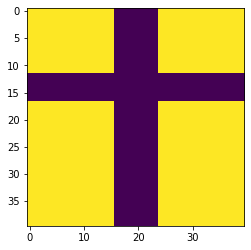

In [3]:
#get files from 'patterns' directory. You can put your own pictures in there if you want
files = glob.glob(os.path.join('patterns','*.jpg')) #where are the patterns stored?

#from these files, define patterns of numbers
patterns=np.array([from_jpg(p) for p in files]) #put individual patterns in array

#remember how large the patterns are
side=int(np.sqrt(len(patterns[0]))) #assume all patterns the same shape


plt.figure()
plt.imshow(patterns[0].reshape(40,40))
print ("Unique image values: ", 
       np.unique(patterns[0]),
       np.unique(patterns[1]),
       np.unique(patterns[2]))
print ("NOTE: values of picutres are -1s and +1s - NOT 0s and 1s")
plt.show()

Let's have a look at our patterns

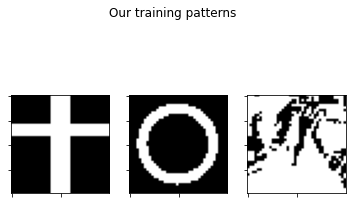

In [4]:
# Four axes, returned as a 2-d array
f, axarr = plt.subplots(1,len(patterns))

for p in range(len(patterns)):
    #axarr[0, p].imshow(patterns[p].reshape((side,side)),cmap=cm.binary, interpolation='nearest')
    axarr[p].imshow(patterns[p].reshape((side,side)), cmap="binary")
    #axarr[0, p].set_title('Cue' + str(p))
    
# Fine-tune figure; hide x ticks for top plots and y ticks for right plots
plt.setp([a.get_xticklabels() for a in axarr[:]], visible=False)
plt.setp([a.get_yticklabels() for a in axarr[:]], visible=False)
plt.suptitle('Our training patterns')
plt.savefig('trainingpatterns.png') #save a file


The Hopfield Network learns patterns of association. In this case, the association is between pixels in the images.

train weights


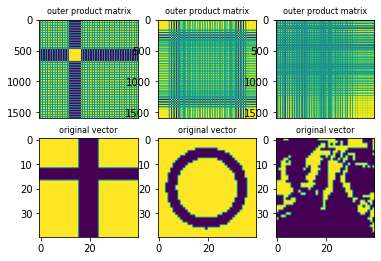

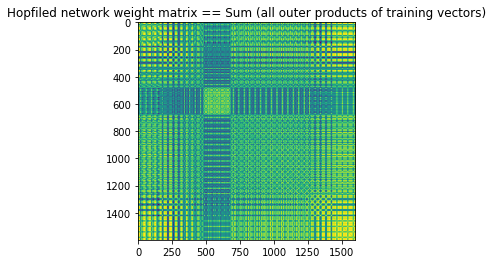

In [5]:
#####################################################
#####################################################
#####################################################

def train2(patterns):
    #This trains a network to remember the patterns it is given
    # - since it is important I'll comment each line
    
    from numpy import zeros, outer, diag_indices  #import functions for vector calculus
    
    #
    r,c = patterns.shape #take the patters and make them vectors. There is a neuron for each pixel in the patterns
    
    #
    W = zeros((c,c)) #there is a weight between each neuron in the network
    
    #
    plt.figure()
    ctr=0
    for p in patterns: # for each pattern
        W = W + outer(p,p) # change the weights to reflect the correlation between pixels
                            # this is the most important step here:
                            # - it creates a connectivity/weight matrix between all pixels
                            #   where 1s mean that both pixels are the same, i.e. correlated
                            #   -1s means the pixels are opposite
                            # - This info is in sections 5.2 and 5.3 of the Hoppfield network section
                            # - TLDR: we want all pixel values to be pushed towards their default values (i.e. -1s to be pushed towards -1)
                            #   so the way to achieve this is to set weights between 2 pixels accordingly (-1 between different pixels; +1 for same)
                            
                            # 2nd step: Summing over all outer products
                            # - this has the effect of adjusting the weigths based on the cumulative sum over all training images
                            #   so it pushes node weights towards the average or mean (or cumulative to be more precise) imagge correlation
                            
                            # in the decoding/or recall step - we actually convert the negative values to -1s and the positive to +1s 
                            # - this rebinarizes the data back to its original range
        
        
        ax=plt.subplot(2,3,ctr+1)
        plt.imshow(outer(p,p))
        plt.title("outer product matrix",fontsize=8)
        plt.xticks([])
        
        ax=plt.subplot(2,3,ctr+4)
        plt.imshow(p.reshape(40,40))
        plt.title("original vector",fontsize=8)
        ctr+=1
    
    #
    W[diag_indices(c)] = 0 # neurons are not connected to themselves (ie the weight is 0)
    
    #
    return W/r #send back the normalised weights; i.e. for 3 training images, we divide by 3

print ("train weights")


# this computes the self correlation between the entire images and single pixels?
W = train2(patterns) 


plt.figure()
plt.imshow(W)
plt.title("Hopfiled network weight matrix == Sum (all outer products of training vectors)")
plt.show()

We have defined a network which has 'learnt' associations between pixels. Now the fun begins. We can explore the emergent properties of this network to see just what networks of simple neurons can do. We can ask if the way the Hopfield network behaves has any lessons to teach us about human memory.

#simple recall

In the graph below the first row shows the pattern the network is shown (the starting activity). The second row shows the pattern of activity after the neurons are allowed to send signals back and forth

pre boolianization # of unique states (10,) [-784.33333333 -553.66666667 -511.         -280.33333333 -280.33333333
  280.33333333  280.33333333  511.          553.66666667  784.33333333]
post boolianization  # of unique states:  (2,) [-1.  1.]

pre boolianization # of unique states (8,) [-771.66666667 -541.         -523.66666667 -293.          293.
  523.66666667  541.          771.66666667]
post boolianization  # of unique states:  (2,) [-1.  1.]

pre boolianization # of unique states (10,) [-793.         -793.         -545.         -519.66666667 -271.66666667
  271.66666667  519.66666667  545.          793.          793.        ]
post boolianization  # of unique states:  (2,) [-1.  1.]

NOTE: the values of the unique pre boolienazation step are very pooolarized -i.e. very far from 0
      - this means that our networks have sufficient depth (?!) to reconstruct multiple types of images given non-corrupted input


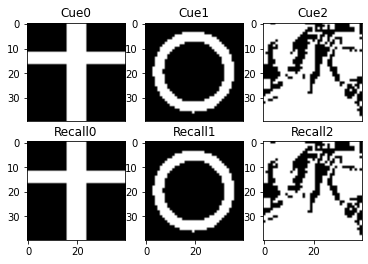

In [24]:
####################################################################
####################################################################
####################################################################

def vector_to_boolean_vector(data):
    ''' Convert data into -1s and +1s     
    '''
    if True:
        idx1 = np.where(data<0)[0]
        idx2 = np.where(data>=0)[0]
        data[idx1]=-1
        data[idx2]=+1

    #
    return data

def recall2(W, pattern, steps=5):
    
    #The tests the network. You give it a pattern and see what it produces
    from numpy import vectorize, dot #vector calculus functions
    
    # original code
    # sgn = vectorize(lambda x: -1 if x<0 else +1) # convert input pattern into a -1/+1 pattern
    

    
    # original code
    #for _ in range(steps): #over a number of iterations (defined by 'steps')    
    #    patterns = sgn(dot(patterns,W)) #adjust the neuron activity to reflect the weights
    
    #patterns2 = np.zeros(pattern.shape)
    #for k in range(len(patterns)):
    for q in range(steps):
        #print (pattern.shape, W.shape)
        temp = dot(pattern,W)           # The first step 
                                        # - Determine the state of each pixel in the reconstructed image by summing over all connected states * weights
                                        #   - this has the overall effect of pushing the pixel space far into 
        
        if q==0:
            print ("pre boolianization # of unique states", np.unique(temp).shape, np.unique(temp))
        temp = vector_to_boolean_vector(temp)
        
        if q==0:
            print ("post boolianization  # of unique states: ", np.unique(temp).shape, np.unique(temp))
        pattern = temp
        
    print ("")
    
    #
    return pattern #return the final pattern
    


# Four axes, returned as a 2-d array
f, axarr = plt.subplots(2, len(patterns))

for p in range(len(patterns)):

    #
    axarr[0, p].imshow(patterns[p].reshape((side,side)), cmap="binary")
    axarr[0, p].set_title('Cue' + str(p))
    axarr[0,p].set_xticks([])
    
    #
    axarr[1, p].imshow(recall2(W,patterns[p]).reshape((side,side)),
                       #vmin=0,
                       #vmax=0.1,
                       cmap="binary")
    axarr[1, p].set_title('Recall' + str(p))

    
    #
print ("NOTE: the values of the unique pre boolienazation step are very pooolarized -i.e. very far from 0")
print ("      - this means that our networks have sufficient depth (?!) to reconstruct multiple types of images given non-corrupted input")
    
    
# Fine-tune figure; hide x ticks for top plots and y ticks for right plots
#plt.setp([a.get_xticklabels() for a in axarr[0, :]], visible=False)
#plt.setp([a.get_xticklabels() for a in axarr[1, :]], visible=False)
#plt.setp([a.get_yticklabels() for a in axarr[:, 0]], visible=False)
#plt.setp([a.get_yticklabels() for a in axarr[:, 1]], visible=False)
#plt.suptitle('Test with training patterns')
#plt.savefig('fullcue.png')


They should match. Graphically this isn't very interesting, but it means that the network doesn't move away from the pattern it is shown if it has been trained it before. Is this something like what our memories do when we recognise something?

#Recognition with noisy inputs

You can recognise a face you've seen before in a new circumstances. You can recognise someone on a dark night, in the rain, even if they've changed their haircut. What does this mean to our network? Well, we can't give our patterns makeup, but we can alter them at random and see what how our network responds'

pre boolianization # of unique states (26,) [-143.         -141.         -127.         -125.         -125.
  -89.66666667  -89.66666667  -87.66666667  -87.66666667  -73.66666667
  -73.66666667  -71.66666667   71.66666667   73.66666667   73.66666667
   87.66666667   87.66666667   89.66666667   89.66666667  125.
  125.          127.          141.          141.          143.
  143.        ]
post boolianization  # of unique states:  (2,) [-1.  1.]

pre boolianization # of unique states (28,) [-173.         -171.         -134.33333333 -132.33333333  -93.
  -91.          -91.          -54.33333333  -54.33333333  -52.33333333
  -52.33333333  -52.33333333   52.33333333   52.33333333   52.33333333
   54.33333333   54.33333333   91.           91.           93.
   93.           93.          132.33333333  132.33333333  134.33333333
  134.33333333  171.          173.        ]
post boolianization  # of unique states:  (2,) [-1.  1.]

pre boolianization # of unique states (29,) [-174.33333333 -172.33

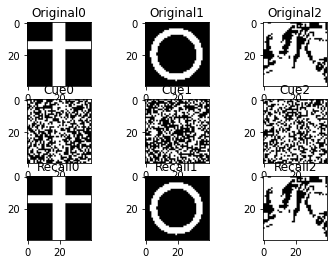

In [54]:
####################################################################################
####################################################################################
####################################################################################

#
def boolean_flip_random(data, 
                       noise_level):
    ''' Convert data into -1s and +1s     
    '''

    # select random numbers between 0 and 1 (uniformly dstirbuted)
    rnd = np.random.random(data.shape[0])
    
    # for all values < noise level flip them
    idx = np.where(rnd<noise_level)[0]
        
    #
    data[idx] = data[idx]*-1
        
    #
    return data

#
def add_random_noise_flips(pattern,
                           noise_level):
    
    #This allows you to add noise to a pattern
    
    #sgn=np.vectorize(lambda x: x*-1 if np.random.random()<noise else x)
    
    pattern = boolean_flip_random(pattern.copy(),
                                         noise_level)
    
    return pattern

#

#reload original patterns. 
patterns=np.array([from_jpg(p) for p in files]) #put individual patterns in array

#
noise_level=0.4

#
testpatterns= [] 
for k in range(len(patterns)):
    testpatterns.append(add_random_noise_flips(patterns[k],
                                              noise_level))


# Four axes, returned as a 2-d array
f, axarr = plt.subplots(3, len(patterns))

for p in range(len(testpatterns)):
    
    #
    axarr[0, p].imshow(patterns[p].reshape((side,side)), cmap="binary")
    axarr[0, p].set_title('Original' + str(p))

    #
    axarr[1, p].imshow(testpatterns[p].reshape((side,side)), cmap="binary")
    axarr[1, p].set_title('Cue' + str(p))
    
    # 
    axarr[2, p].imshow(recall2(W,testpatterns[p]).reshape((side,side)), cmap="binary")
    axarr[2, p].set_title('Recall' + str(p))
    
    
# # Fine-tune figure; hide x ticks for top plots and y ticks for right plots
# plt.setp([a.get_xticklabels() for a in axarr[0, :]], visible=False)
# plt.setp([a.get_xticklabels() for a in axarr[1, :]], visible=False)
# plt.setp([a.get_yticklabels() for a in axarr[:, 0]], visible=False)
# plt.setp([a.get_yticklabels() for a in axarr[:, 1]], visible=False)
# plt.suptitle('Test with noisy cue')
# plt.savefig('noisycue.png')


In the cell above the amount of noise is defined as 0.1. That's 10% of pixels randomly switched. What happens if you change that number? How is the system responding?

What you are seeing is sometimes called 'graceful degredation'. That means that the system fails gradually - it doesn't need the exact right inputs to guess the right pattern. Consider:

Yuo nca unredstnad thsi

Human information processing is often very good at coping with noisy inputs. Computers, not so much.


#Recognition from partial cues

pre boolianization # of unique states (19,) [-299.66666667 -299.66666667 -238.33333333 -169.         -107.66666667
  107.66666667  107.66666667  109.66666667  109.66666667  169.
  171.          171.          238.33333333  240.33333333  240.33333333
  299.66666667  299.66666667  301.66666667  301.66666667]
post boolianization  # of unique states:  (2,) [-1.  1.]

pre boolianization # of unique states (17,) [-255.         -167.         -167.         -157.66666667  -69.66666667
   69.66666667   71.66666667   71.66666667  157.66666667  159.66666667
  159.66666667  167.          167.          169.          169.
  255.          257.        ]
post boolianization  # of unique states:  (2,) [-1.  1.]

pre boolianization # of unique states (16,) [-783.66666667 -414.33333333 -407.66666667 -407.66666667  -38.33333333
   38.33333333   40.33333333   40.33333333   40.33333333  407.66666667
  407.66666667  409.66666667  414.33333333  416.33333333  783.66666667
  785.66666667]
post boolianization  # of

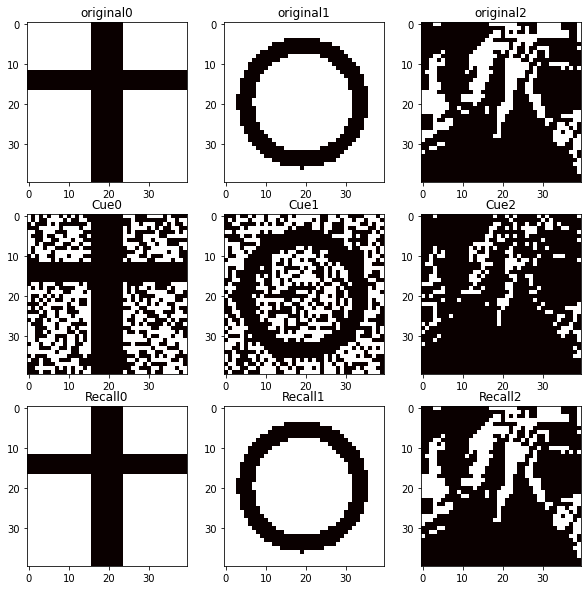

In [73]:
####################################################################################
####################################################################################
####################################################################################


def occlude_image_continuous(p,
                  proportion):
    
    # 
    u=int(proportion*len(p))
    new_p=p.copy()
    new_p[:u]=-1
    return new_p



def occlude_image_random(p,
                      proportion):
    
    # 
    u=int(proportion*len(p))
    idx = np.random.choice(np.arange(p.shape[0]), u, replace=False)
    new_p = p.copy()
    new_p[idx] = -1
    return new_p

#reload original patterns otherwise being overwritten as they are pointer-sahred
patterns=np.array([from_jpg(p) for p in files]) #put individual patterns in array
   
#
proportion=0.45
testpatterns=[]
for k in range(len(patterns)):
    #testpatterns.append(occlude_image_continuous(patterns[k], proportion))
    testpatterns.append(occlude_image_random(patterns[k], proportion))

 # Four axes, returned as a 2-d array
f, axarr = plt.subplots(3, len(testpatterns),
                       figsize=(10,10))

for p in range(len(testpatterns)):
    
    #
    axarr[0, p].imshow(patterns[p].reshape((side,side)), cmap="hot")
    axarr[0, p].set_title('original' + str(p))
    
    #
    axarr[1, p].imshow(testpatterns[p].reshape((side,side)), cmap="hot")
    axarr[1, p].set_title('Cue' + str(p))
    
    #
    axarr[2, p].imshow(recall2(W,testpatterns[p]).reshape((side,side)), cmap="hot")
    axarr[2, p].set_title('Recall' + str(p))

# # Fine-tune figure; hide x ticks for top plots and y ticks for right plots
# plt.setp([a.get_xticklabels() for a in axarr[0, :]], visible=False)
# plt.setp([a.get_xticklabels() for a in axarr[1, :]], visible=False)
# plt.setp([a.get_yticklabels() for a in axarr[:, 0]], visible=False)
# plt.setp([a.get_yticklabels() for a in axarr[:, 1]], visible=False)
# plt.suptitle('Test with partial cue')
# plt.savefig('partialcue.png')

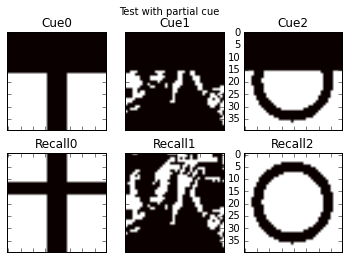

So the network can recover the patterns it was trained on from a partial cue. Compare to how you can remember someone's name from their face, or the answer to the question "what is the capital of France?"

What happens as you change the amount of the original pattern that is removed?